In [1004]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/DESI-QA/")
import find_center as fc
from spotfinder import spotfinder

plt.rcParams.update({'figure.dpi':140})


In [1005]:
def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def find_spot(fitsname, fitspath,  
              expected_spot_count=1, 
              regionsname='../regions.reg', 
              verbose=False):
    """
    spotfinder handler
    input:
        fitsname:
        fitspath (str): relative or full path to the folder
        regionsname (str):
        verbose (bool):
    output: 
        centroids (dict): raw output from spotfinder

    """
    import os
    
    assert isinstance(fitsname, str)

    _ifn = f"{fitspath}/{fitsname}"
    if not (os.path.isfile(_ifn)):
        print(f"File not found \n{_ifn}")
#     if expected_spot_count != 1:
#         raise NotImplementedError("This mode wasn't tested here")
    try: 
        sf=spotfinder.SpotFinder(_ifn, expected_spot_count)
        centroids = sf.get_centroids(print_summary = verbose, 
                                     region_file=regionsname)
        if verbose: print(centroids)
    
    except Exception as err: #ignore photo if an error is raised
        print(f"{err}\nWarning: spot not found ")
        inval_number = np.nan
        return {  'peaks': [inval_number], 
                      'x': [inval_number], 
                      'y': [inval_number], 
                   'fwhm': [inval_number], 
                 'energy': [inval_number]} 
    return centroids


def collect_xy(files, picspath):
    # treating for single file
    if isinstance(files, str):
        files = [files]
    x2, y2 = [],[]
    for fullname in files:
        iname = fullname.split('/')[-1]
        _c = find_spot(iname, picspath)
        x2.append(_c['x'])
        y2.append(_c['y'])
    return x2, y2

# Fiducial calibration

TURN ON FIDUCIAL, TURN OFF POSITIONER BACKLIGHT

In [1003]:
from astropy.io import fits 
fiducial_pic = "20230523-110411.fits" 
# fiducial_pic = "20230522-093243.fits" - different fiducial
fiducial_path = '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409'
dd = find_spot(fiducial_pic, 
               fiducial_path, 
               regionsname=False, 
               expected_spot_count=4)

File not found 
/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits
[Errno 2] No such file or directory: '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits'


In [5]:
img = fits.getdata(f"{fiducial_path}/{fiducial_pic}")

plt.subplot(121)
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
plt.gca().invert_yaxis()
plt.subplot(122)
plt.gca().invert_yaxis()
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
for pt, (i,j) in enumerate(zip(dd['x'], dd['y'])):
    plt.annotate(pt, xy=(i-5,j+8), xycoords='data')
plt.ylim([800, 950])
plt.xlim(1000, 1200)

FileNotFoundError: [Errno 2] No such file or directory: '/home/msdos/DESI-QA/sbigpics/getpic-20230523-110409/20230523-110411.fits'

In [5]:
cx = np.array(dd['x'])
cy = np.array(dd['y'])
d = lambda i, j: np.hypot(cx[j] -cx[i], cy[j] - cy[i])

# User should MATCH ORDER OF SPOTS
dphys = { (3,2):1,(3,1):2, (3,0):1.6, (2,1):1, (2,0):1,  (1,0):1.2  }
ratioall = np.array([])
dph =  np.array([1, 2, 1.6, 1, 1, 1.2]) # weighting by the distance
pix2mm = np.array([])
for i,j in [(3,2), (3,1), (3,0), (2,1), (2,0), (1,0)]:
    _x = d(i,j)/dphys[(i,j)]
    ratioall = np.append(ratioall, _x)
    pix2mm = np.append(pix2mm, dphys[(i,j)]/d(i,j))
# assert pix2mm
    
print(f"{ratioall.mean():.4f} +/- {np.std(ratioall, ddof=1):.4f}")
mu_mm2pix = (ratioall*dph).sum() /dph.sum()
std_mm2pix = np.sqrt( np.sum(dph* (ratioall-mu_mm2pix)**2)/ ( dph.sum() * (len(dph)-1)/len(dph) ) )

def stats(pix2mm, w):
    # w: dph Physical distance in the model
    N = len(w!=0)
    _mu = np.sum(pix2mm * w)/w.sum()
    _std = np.sum(w * (pix2mm - _mu)**2)/( w.sum() * ((N-1)/N) )
    _std = np.sqrt(_std)
    return _mu, _std

# ------------
# Calibration 
# weighting values based on the (expected) distance size from template
mu1, std1 = stats(pix2mm, dph)
mu2, std2 = stats(pix2mm, np.ones_like(pix2mm))
    
print(f"weighted: {mu_mm2pix:.4f} +/- {std_mm2pix:.4f}" )
print(f"weighted: {mu1:.6f} +/- {std1:.6f}" )
ratioall, (ratioall*dph).sum() /dph.sum(),  #mu2, std2, 1/mu2

31.6872 +/- 16.2997
weighted: 28.2745 +/- 16.0047
weighted: 0.044800 +/- 0.021493


(array([28.24232837, 14.15258891, 17.68625956, 56.54747486, 45.22697419,
        28.26777886]),
 28.274526302738305)

In [77]:
# pix2mm =  0.035406 # +/- 0.000019
pix2mm = 1/mu_mm2pix # +/- 1/std_mm2pix - sean's run
pix2mm

0.03536752443853155

# Positional Calibration

TURN OFF FIDUCIAL, TURN ON POSITIONER BACKLIGHT

In [1056]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    """
    Setup for plot with args xc, yc, and Radius
    """
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.ylim(yc- rmax , yc+rmax)
    plt.xlim(xc+rmax, xc-rmax)
    
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)

def plot_circle(xc, yc, R, kwargs={}):
    _th = np.linspace(0, 2*np.pi)
    plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='g', ls='--', lw=0.6)
    return 

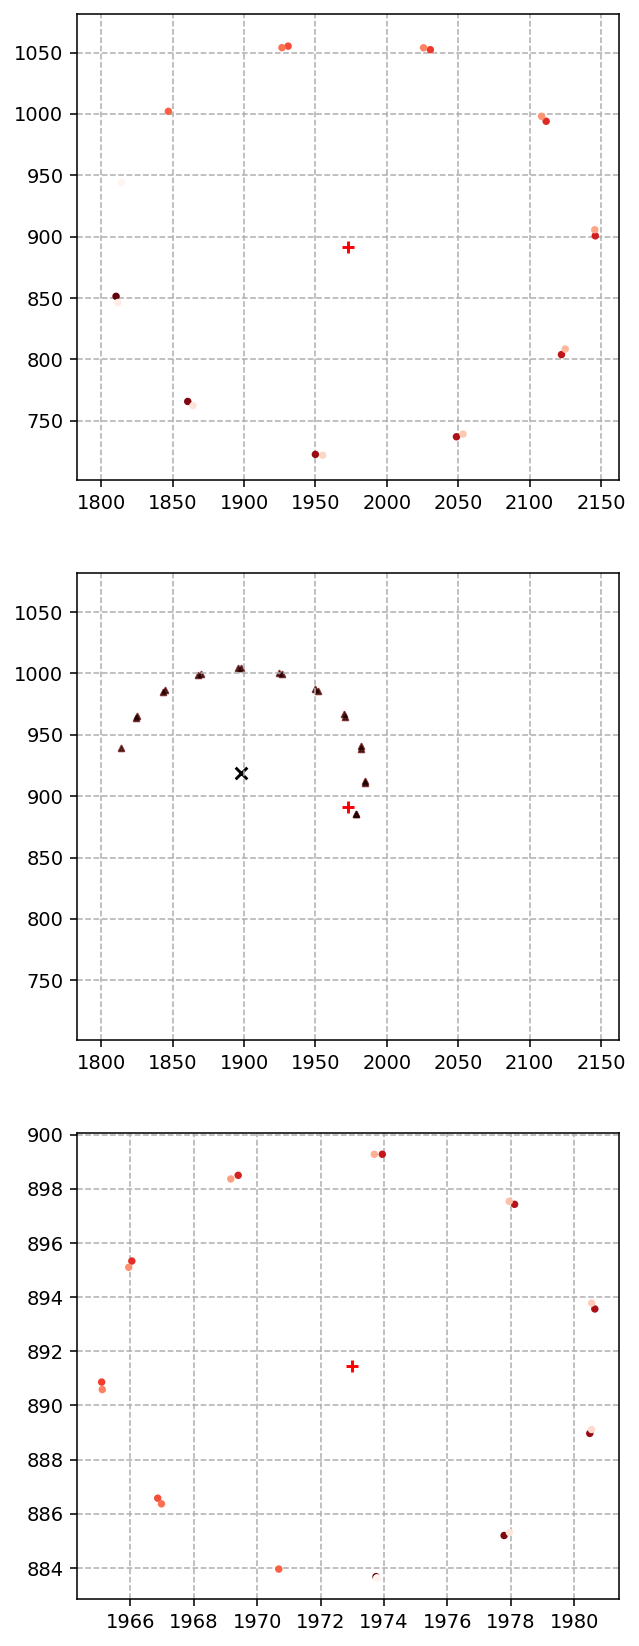

In [1089]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)

color2='b'
color1=color2

dateStart = np.array(['2023-06-14 12:19:00','2023-07-02 16:30:00','2023-06-20 18:08:00'],dtype='datetime64') # arcth time, arcph time, and arcth30small time
dateEnd = dateStart+np.timedelta64(4,'m')

m1 =  query_time(db, datemin=dateStart[0],datemax=dateEnd[0])
m1 = (m1) & ( db['label'].str.contains('arcth') )  & (db['motor']=='theta')
# m1 = (m1) & (db['direction']=='cw')

m2 = query_time(db, datemin=dateStart[1],datemax=dateEnd[1])
m2 = (m2) & ( db['label'].str.contains('arcph') )

m3 = query_time(db, datemin=dateStart[2],datemax=dateEnd[2])
m3 = (m3) & ( db['label'].str.contains('arcth30smallPhi') )

fig,axs = plt.subplots(3,1,figsize=[5,15])

x_center,y_center,offset,small_scalar = xc/pix2mm,yc/pix2mm, 190,2

axs[0].scatter('xpix', 'ypix', data=db[m1], c=np.arange(m1.sum()), cmap='Reds_r',  s=8, zorder=10)
# axs[0].scatter('xpix', 'ypix', data=db[m1].loc[2615], c='black', s=8, zorder=10)
axs[0].set_ylim(y_center-offset,y_center+offset)
axs[0].set_xlim(x_center-offset,x_center+offset)
axs[0].scatter(x_center,y_center,marker='+',c='red')
axs[0].grid(ls='--')

axs[1].scatter('xpix', 'ypix', data=db[m2], c='r', marker='^', s=8, alpha=0.5)
axs[1].scatter('xpix', 'ypix', data=db[m2], c='black', marker='^', s=8, alpha=0.5)
axs[1].scatter(xc2/pix2mm,yc2/pix2mm,marker='x',c='black')
axs[1].set_ylim(y_center-offset,y_center+offset)
axs[1].set_xlim(x_center-offset,x_center+offset)
axs[1].scatter(x_center,y_center,marker='+',c='red')
axs[1].grid(ls='--')

axs[2].scatter('xpix', 'ypix', data=db[m3], c=np.arange(m3.sum()), cmap='Reds_r',  s=8, zorder=10)
# axs[2].set_ylim(y_center-offset*small_scalar,y_center+offset*small_scalar)
# axs[2].set_xlim(x_center-offset*small_scalar,x_center+offset*small_scalar)
axs[2].scatter(x_center, y_center,marker='+',c='red')
axs[2].grid(ls='--')

plt.show()

In [1070]:
xc_small, yc_small, Rarc_small= [i*pix2mm for i in fc.get_circle(db[m3],)]
print(f'mm center from small circle: [{xc_small},{yc_small}]')
print(f'Pixel center from small circle: [{xc_small/pix2mm},{yc_small/pix2mm}]')

mm center from small circle: [69.77972167673121,31.529107849530625]
Pixel center from small circle: [1972.9885759464948,891.4705891934263]


In [1090]:
db[m2]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
12928,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163016,4852,cw,cruise,phi,0.0,1978.388812,885.291580,0,76964.1747,3.5345
12929,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163026,4852,cw,cruise,phi,15.0,1984.484538,910.399436,0,76302.6357,3.5539
12930,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163034,4852,cw,cruise,phi,15.0,1982.208521,938.835882,0,78460.8174,3.5031
12931,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163043,4852,cw,cruise,phi,15.0,1970.855524,964.911699,0,78687.0391,3.5100
12932,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163053,4852,cw,cruise,phi,15.0,1951.575461,985.950554,0,78307.5061,3.5590
12933,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163102,4852,cw,cruise,phi,15.0,1926.428221,999.605419,0,77426.5748,3.6258
12934,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163112,4852,cw,cruise,phi,15.0,1898.073090,1004.349414,0,78894.3303,3.6535
12935,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163120,4852,cw,cruise,phi,15.0,1869.871260,999.700027,0,79140.9610,3.6510
12936,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163129,4852,cw,cruise,phi,15.0,1844.682462,986.120800,0,79213.3787,3.7308
12937,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163139,4852,cw,cruise,phi,15.0,1825.164609,965.079662,0,80054.6300,3.8732


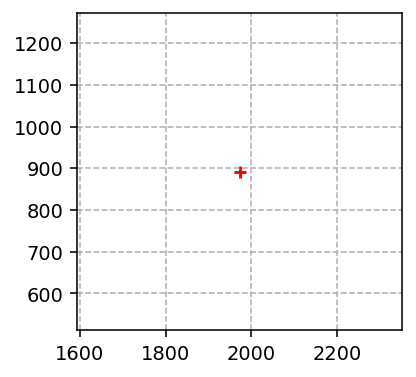

In [1072]:
fig,ax = plt.subplots(figsize=[3,3])

# plt.scatter('xpix', 'ypix', data=db[m2].loc[2616], c='black',  s=8)
plt.ylim(y_center-offset*small_scalar,y_center+offset*small_scalar)
plt.xlim(x_center-offset*small_scalar,x_center+offset*small_scalar)
plt.scatter(x_center, y_center,marker='+',c='red')
plt.grid(ls='--')
plt.show()

In [1073]:
pix2mm = 0.03536752443853155 # PLACEHOLDER!

# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)] # center and radius of theta arc
# print(xc1, yc1, Rarc1)


xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])] # center and radius of phi arc
# print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)

# Capturing important pixels for hardstop angle - I think pix2mm is the incorrect naming convention, it should be millimeters to pixel? so long as we know moving forward - Sean
hardStop = angle_between(np.array([xc,yc]), np.array([xc+5,yc]), (xc2,yc2))

# computing the small offset of the exclusion zone, taken at first point of the hardstop
small_offsets = np.array([db[m3][['xpix','ypix']].reset_index(drop=True).iloc[0]['xpix'],db[m3][['xpix','ypix']].reset_index(drop=True).iloc[0]['ypix']])*pix2mm-np.array([xc,yc])
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1 (mm): {R1:.8} \nR2 (mm): {R2:.8}")
print(f"xc, yc (mm): [{xc:.5f}, {yc:.5f}]")
print(f"Hardstop angle (degrees): {hardStop:.5f}")
print(f"pix2mm {pix2mm}")
print(f"pixcenter [{xc/pix2mm:.5f}, {yc/pix2mm:.5f}]")
print(f"offset of phi arm at home position (mm) [{small_offsets[0]:.5f},{small_offsets[1]:.5f}] ")

R1 (mm): 2.9170981 
R2 (mm): 3.0709296
xc, yc (mm): [69.88609, 31.50866]
Hardstop angle (degrees): 161.10542
pix2mm 0.03536752443853155
pixcenter [1975.99596, 890.89238]
offset of phi arm at home position (mm) [-0.07942,-0.25520] 


In [1074]:
m2 = query_time(db, datemin='2023-05-25 17:25:00')
m2 = (m2) & ( db['label'].str.contains('arcph') )
color2 = ['b' if i =='cw' else 'r' for i in db['direction'][m2]]

m1 = query_time(db, datemin='2023-05-23 13:18:00')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')
color1 = ['b' if i =='cw' else 'r' for i in db['direction'][m1]]

# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)] # center and radius of theta arc
# print(xc1, yc1, Rarc1)


xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])] # center and radius of phi arc
# print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)

# Capturing important pixels for hardstop angle - I think pix2mm is the incorrect naming convention, it should be millimeters to pixel? so long as we know moving forward - Sean
hardStop = angle_between(np.array([xc,yc]), np.array([xc+5,yc]), (xc2,yc2))
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1 (mm): {R1:.8} \nR2 (mm): {R2:.8}")
print(f"xc, yc (mm): [{xc:.5f}, {yc:.5f}]")
print(f"Hardstop angle (degrees): {hardStop:.5f}")
print(f"pix2mm {pix2mm}")
print(f"pixcenter [{xc/pix2mm:.5f}, {yc/pix2mm:.5f}]")

R1 (mm): 4.1493416 
R2 (mm): 3.0170246
xc, yc (mm): [71.02805, 31.10518]
Hardstop angle (degrees): 160.58524
pix2mm 0.03536752443853155
pixcenter [2008.28440, 879.48410]


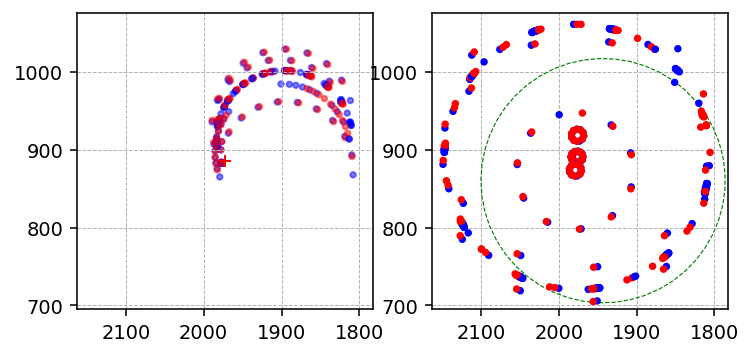

In [203]:
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], c=color2, s=8, alpha=0.5)
setplot(1973, 885, 190)

plt.subplot(122)

plt.scatter('xpix', 'ypix', data=db[m1], c=color1, s=8, zorder=10)
plot_circle(xc/pix2mm, yc/pix2mm, (R1+R2)/pix2mm)
setplot(1973, 885, 190)

In [11]:
db['xmm'] = db["xpix"].values * pix2mm #-xc
db['ymm'] = db["ypix"].values * pix2mm #-yc

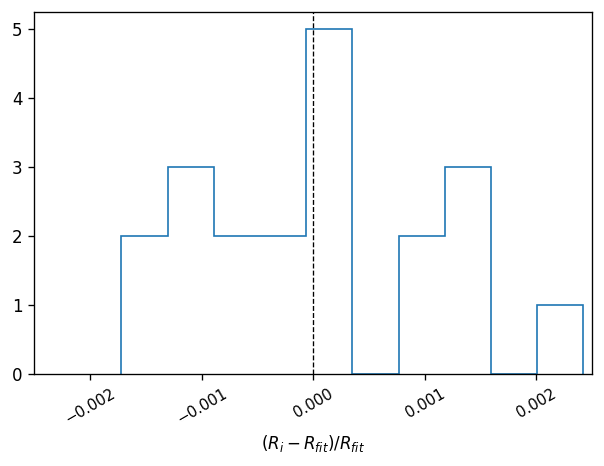

In [12]:
# msk_arcth1 =( db['label'].str.contains('arcth30') )| (db['direction']=='cw') & (query_time(db, "2023-02-07"))
DR = np.hypot(db['xmm'][m1] - xc, db['ymm'][m1] - yc)
DRcw = np.hypot(db['xmm'][m1 & (db.direction=='cw')] - xc, db['ymm'][m1& (db.direction=='cw')] - yc)
DRccw = np.hypot(db['xmm'][m1 & (db.direction=='ccw')] - xc, db['ymm'][m1& (db.direction=='ccw')] - yc)

plt.hist(DR - Rarc1 , histtype='step', density=False)
# plt.hist(DRcw- Rarc1, histtype='step', density=True)
# plt.hist(DRccw -Rarc1, histtype='step', density=True)


plt.xlabel("$ (R_i - R_{fit})/ R_{fit}$")
plt.xticks(fontsize=9, rotation =30); 
plt.xlim(-0.0025, 0.0025)
plt.axvline(0, c='k',lw=0.8, zorder=0, ls='--')

In [13]:
askedangle = db[m2]['angle'].values * np.array( [1 if i =='ccw' else -1 for i in  db[m2]['direction']])

In [14]:
# #CW
# dang=[]
# correction = -2*1.995
# kwplot = dict(marker='o', edgecolors='k', alpha=0.6)
# msk = (m2) & (db['direction'] == 'cw')
# c = ['b' if i == 'cw' else 'r' for i in db[msk]['direction']]

# for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
#     dang.append(angle_between((xc2,yc2), (-6,0), (i, j)))
    
# dang = np.array(dang)[0:]
# displ = dang[1:]-dang[:-1] 
# plt.scatter(range(len(dang)-1), -displ + 0*correction, c='b', #c[1:], 
#          label='', **kwplot)

# plt.scatter(range(len(dang)-1), askedangle[1:] + -correction*np.sign(askedangle[1:]), marker='x', 
#          alpha=0.6)

# CCW
dang=[]
msk = (m2) & (db['direction'] == 'cw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = -np.array(dang)[2:-3]

plt.scatter(range(len(dang)-1), dang[1:]-dang[:-1] + correction, c='b', 
            label='cw', **kwplot)


# CCW
dang=[]
msk = (m2) & (db['direction'] == 'ccw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = np.array(dang)[:-3]

plt.scatter(range(5,len(dang)-1 +5), dang[1:]-dang[:-1] + correction, c='r', 
            label='ccw', **kwplot)


plt.ylim(14.5, 15.5)
plt.xlabel("move id")
plt.ylabel("angle (deg)")
plt.grid('--', lw=.4)
plt.title("phi motor")

plt.axhline(15, c='k', zorder=0, lw=.8, label='requested angle')
plt.legend(loc='best', fontsize=8)

plt.show()
plt.plot(np.cumsum(displ) -1*np.cumsum(displ).min())
csumasked = np.cumsum(askedangle[1:] -correction*np.sign(askedangle[1:])) 
plt.plot(csumasked - csumasked.min()  )
plt.grid()

NameError: name 'correction' is not defined

In [ ]:
db[m2]

# xy test

In [ ]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
pix2mm = 0.03536752443853155
xc, yc = [69.96433, 31.51567]

In [ ]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
get_timecol(db)
plt.scatter('xpos', 'ypos', data=get_lastdbxy(12), marker='x')
# plt.scatter('xpos', 'ypos', data = xytgt, marker='.')
plt.gca().set_aspect('equal')
# plt.pause(1)
# plt.show()

In [ ]:
db['session'][db["label"].str.contains('xy60')].unique()

In [ ]:
label='xy60'
dt1, dt2 = '2023-03-09 18:05:35', '2023-03-09 19:01:38'
dt1, dt2 = '2023-03-09 19:05:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 19:45:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:02:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:20:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 21:10:35', '2023-03-09 21:30:38'
dt1, dt2 = '2023-03-10 10:20:00', '2023-03-10 10:22:00' # backlash = 1.8 best case so far
# dt1, dt2 = '2023-03-10 10:40:00', '2023-03-10 10:42:00' # backlash = 2.0
#dt1, dt2 = '2023-03-10 10:58:00', '2023-03-10 10:59:00' # backlash = 1.9
# dt1, dt2 = '2023-03-10 11:13:00', '2023-03-10 11:14:00' # backlash = 1.8 + sleep 01 s

def get_lastdbxy(tail, label='xy60'):
    mxy = db["label"].str.contains(label)
#     mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    dbxy = db[['xpix','ypix']][mxy].tail(tail).reindex()
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def get_dbxy(db,  datemin, datemax, label='xy60'):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def plot_xy(label, datemin, datemax, movefn="XY_60b.txt", title='', show=True ):
    dbxy = get_dbxy(db, datemin, datemax,label='xy60')
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=20)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    plt.scatter('xpos', 'ypos', data=xytgt, edgecolors='r', s=20, c='', lw=1,label='target')
    plt.xlabel('xpos (mm)')
    plt.ylabel('ypos (mm)')
    plt.title(title, fontsize=8)
    plt.xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_xyhist(label, datemin, datemax, dbxy=None, joinplot=False, plotall=False):
    if dbxy is None:
        dbxy = get_dbxy(db, datemin, datemax)
    dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
    rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
    dr = np.hypot(dx, dy)
    if plotall:
        plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
        plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
        plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
        plt.legend(loc='best', fontsize=9)
        plt.show()
    plt.hist(np.hypot(dx,dy), histtype='step')
    plt.xlabel('$\delta r \;(mm)$')
    if not joinplot:
        plt.show()
    return dr
    
plot_circle(0,0, 6.04)
plt.plot(np.linspace(0, 6.04* np.cos(-166)), np.linspace(0, 6.04* np.sin(-166)), lw=1 , c='g', label='hardstop'  )
plt.grid(lw=0.6, ls='--')   
plt.annotate('$1.0\\vec{g}$', xy=(5.3, -6), xycoords='data',
             xytext=(5.3, -5), textcoords='data',
             horizontalalignment='center',
             fontsize=8,
             arrowprops=dict(color='k', lw=.4, width=.4, headwidth=3.0,
                             headlength=3.0, ls='-')
           )
dbxy, xytgt = plot_xy(label, dt1, dt2, title='posid:4852\n2023-03-10T10:21:45' )

rdiff = plot_xyhist(label, dt1, dt2, dbxy=dbxy)



In [ ]:
dados = [rdiff.min(), rdiff.max(), np.median(rdiff), np.sqrt(np.mean(rdiff**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

In [ ]:
rmsk = rdiff<0.2

dados = [rdiff[rmsk].min(), rdiff[rmsk].max(), np.median(rdiff[rmsk]), np.sqrt(np.mean(rdiff[rmsk]**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

In [ ]:
3*np.radians(1)

In [ ]:
np.degrees(np.arctan( (5.789/1.743)**-1))

In [ ]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx/dr, '.-', label='dx/dr', alpha=0.5)
plt.plot(dy/dr, '.-', label='dy /dr', alpha=0.5)
# plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()


In [ ]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')
plt.xlabel('$\delta r \;(mm)$')

In [ ]:
plt.plot(yt)

In [ ]:
8998431243975386
0.5533# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))

label = 'xy60'
xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt + 0.0514)
v = 1e3 * (ypos - yt +  0.01185)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=120
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

np.mean(dr)

In [ ]:
def func(xoff, yoff):
    u = 1e3 * (xpos - xt + xoff)
    v = 1e3 * (ypos - yt + yoff)
    return np.sqrt(np.mean(np.hypot(u, v)**2))



xx,yy = np.random.rand(30000)*2*0.1 -0.1, np.random.rand(30000)*2*0.1 - 0.1

vals = np.array([func(ii,  jj) for (ii, jj) in zip(xx,yy)])
amin = np.argmin(vals)
vals.shape, vals[amin], xx[amin], yy[amin]

In [ ]:
plt.scatter(xx,yy, c=vals, cmap='viridis_r', s=.6 )
plt.plot(xx[amin], yy[amin], 'rx')
plt.xlabel("xoff (um)")
plt.ylabel("yoff (um)")
plt.colorbar(label='RMS')

In [ ]:
m2 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m2 = (m2) & ( db['label'].str.contains('arcph') )
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], s=8)
setplot(1973, 885, 190)

plt.subplot(122)

m1 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')

plt.scatter('xpix', 'ypix', data=db[m1], s=8)
setplot(1973, 885, 190)


In [ ]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4}, R2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

In [ ]:
6*np.sin(np.radians(2)), np.radians(2)

# Observed/expected calculations

In [1091]:
alpha_arr = np.array([],dtype='float16')
req_arr = np.array([],dtype='float16')
obs_arr = np.array([],dtype='float16')

In [1092]:
xc,yc = [69.77972167673121,31.529107849530625]
xc_pix,yc_pix = xc/pix2mm,yc/pix2mm
xc2_pix,yc2_pix = xc2/pix2mm,yc2/pix2mm

## For arcphi sequence

In [1093]:
arcs = db[m2].reset_index(drop=True)

req_move = 15
backlash = 1.9
ramp=1.995

label = "Positioner Horizon - Post-positioner down for night5"

In [1094]:
db[m2]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
12928,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163016,4852,cw,cruise,phi,0.0,1978.388812,885.291580,0,76964.1747,3.5345
12929,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163026,4852,cw,cruise,phi,15.0,1984.484538,910.399436,0,76302.6357,3.5539
12930,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163034,4852,cw,cruise,phi,15.0,1982.208521,938.835882,0,78460.8174,3.5031
12931,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163043,4852,cw,cruise,phi,15.0,1970.855524,964.911699,0,78687.0391,3.5100
12932,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163053,4852,cw,cruise,phi,15.0,1951.575461,985.950554,0,78307.5061,3.5590
12933,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163102,4852,cw,cruise,phi,15.0,1926.428221,999.605419,0,77426.5748,3.6258
12934,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163112,4852,cw,cruise,phi,15.0,1898.073090,1004.349414,0,78894.3303,3.6535
12935,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163120,4852,cw,cruise,phi,15.0,1869.871260,999.700027,0,79140.9610,3.6510
12936,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163129,4852,cw,cruise,phi,15.0,1844.682462,986.120800,0,79213.3787,3.7308
12937,arcph15,2023-07-02 16:30:13,0.0,0.0,20230702-163139,4852,cw,cruise,phi,15.0,1825.164609,965.079662,0,80054.6300,3.8732


In [1095]:
for j in range(len(arcs)-1):
    prev = j
    current = j+1
    
    x_previous, y_previous,direction_previous = arcs.loc[prev]['xpix'],arcs.loc[prev]['ypix'],arcs.loc[prev]['direction']
    x_current, y_current,direction_current = arcs.loc[current]['xpix'],arcs.loc[current]['ypix'],arcs.loc[current]['direction']
    
    if direction_previous!=direction_current or j==0:
        alpha_arr = np.append(alpha_arr,angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),(x_current, y_current))/(req_move+ramp))
        req_arr = np.append(req_arr,req_move+ramp)
        
    else:
        alpha_arr = np.append(alpha_arr,angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),(x_current, y_current))/(req_move+2*ramp))
        req_arr = np.append(req_arr,req_move+2*ramp)
    
    obs_arr = np.append(obs_arr, angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),(x_current, y_current)))

In [1096]:
indices = np.arange(0,19,step=1,dtype=int)
# indices = np.delete(indices,[10,18])
# print(indices)

Median alpha: 1.0055395777960365


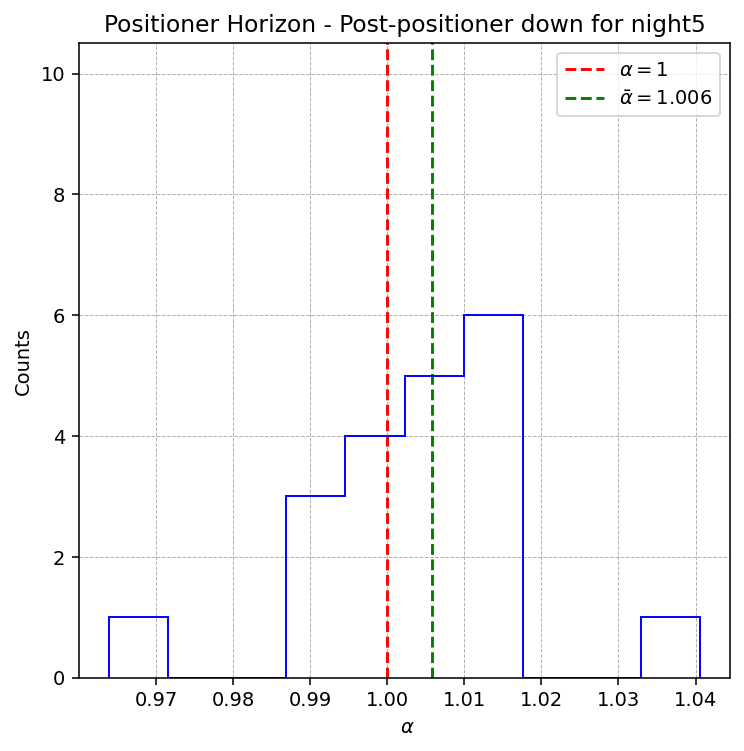

In [1097]:
fig,ax = plt.subplots(figsize=[6,6])
ax.grid(linestyle='--',linewidth=0.5)
ax.vlines(1,0,11,label=r'$\alpha = 1$',linestyle='--',color='red')
ax.vlines(np.median(alpha_arr[indices]),0,11,label=r'$\bar{\alpha} = $'+f'{np.median(alpha_arr[indices]):.3f}',linestyle='--',color='green')
ax.set_ylim(0,10.5)
ax.legend()
ax.hist(alpha_arr,histtype='step',color="blue")
ax.set_title(label)

ax.set_xlabel(r' $\alpha$')
ax.set_ylabel('Counts')

print("Median alpha:",str(np.median(alpha_arr)))

plt.savefig('/home/msdos/DESI-QA/output/figures/LinPhiTests/Hist_'+str(label)+'.jpg',dpi=180)

plt.show()

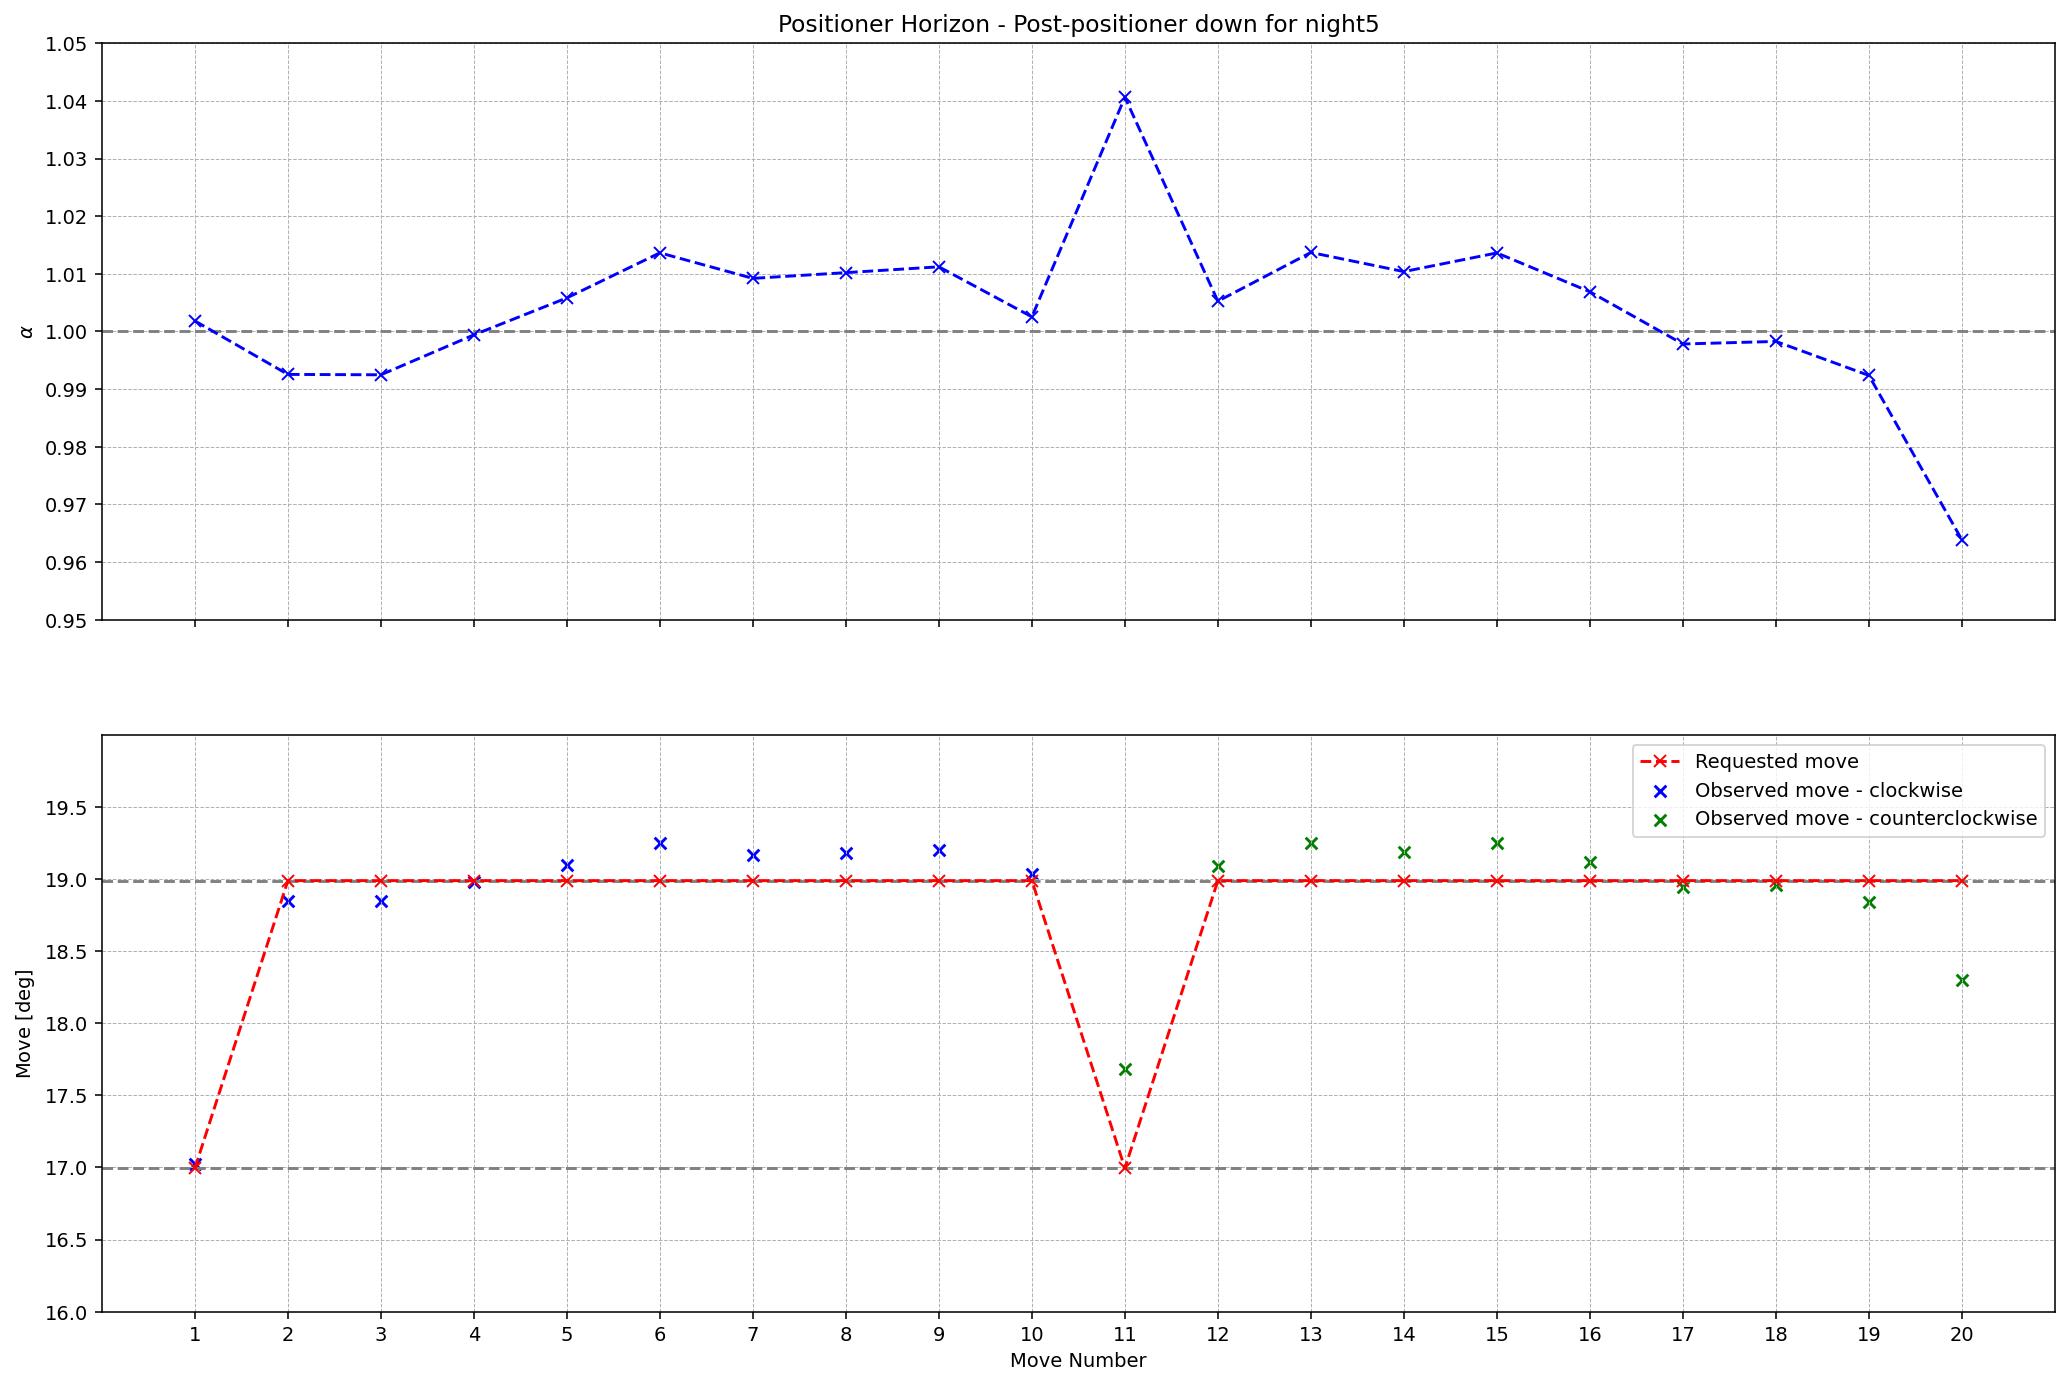

In [1098]:
fig,axs = plt.subplots(2,1,figsize=[18,12],sharex=True)

axs[0].set_ylim(0.95,1.05)
axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].hlines(0,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0].hlines(1,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0].set_xlim(0,len(alpha_arr)+1)
axs[0].set_ylabel(r"$\alpha$")
axs[0].plot(np.linspace(1,len(alpha_arr),num=len(alpha_arr)), alpha_arr,marker='x',linestyle='dashed',color='blue')
axs[0].set_xticks(np.arange(1,len(req_arr)+1,step=1))
axs[0].set_yticks(np.arange(0.95,1.05,step=.01))
axs[0].set_title(label)

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].hlines(15+1*ramp,-1,len(req_arr)+1,linestyle='--',colors='grey')
axs[1].hlines(15+2*ramp,-1,len(req_arr)+1,linestyle='--',colors='grey')
axs[1].set_xlim(0,len(req_arr)+1)
axs[1].set_xlabel("Move Number")
axs[1].set_ylabel(r"Move $[\deg]$")
axs[1].scatter(np.linspace(1,len(obs_arr)/2,num=int(len(obs_arr)/2)), obs_arr[:10],label="Observed move - clockwise",marker='x',color='blue')
axs[1].scatter(np.linspace(11,len(obs_arr),num=int(len(obs_arr)/2)), obs_arr[10:],label="Observed move - counterclockwise",marker='x',color='green')
axs[1].plot(np.linspace(1,len(req_arr),num=len(req_arr)), req_arr,label="Requested move",marker='x',linestyle='dashed',color='red')
axs[1].legend()
axs[1].set_xticks(np.arange(1,len(req_arr)+1,step=1))
axs[1].set_yticks(np.arange(16,20,step=.5))
axs[1].set_ylim(16,20)

# plt.savefig('/home/msdos/DESI-QA/output/figures/LinPhiTests/Arcs_'+str(label)+'.jpg',dpi=180)

plt.show()

# DEPRECATED

## For end of arctheta sequence

In [544]:
initial = db[m1].loc[2614]
final = db[m1].loc[2615]

In [545]:
alpha_arr = np.append(alpha_arr,angle_between((xc2_pix,yc2_pix),(initial['xpix'],initial['ypix']),(final['xpix'],final['ypix']))/(180+2*backlash))
req_arr = np.append(req_arr,(180+2*backlash))
obs_arr = np.append(obs_arr,angle_between((xc2_pix,yc2_pix),(initial['xpix'],initial['ypix']),(final['xpix'],final['ypix'])))

# Results from moves on 6/21

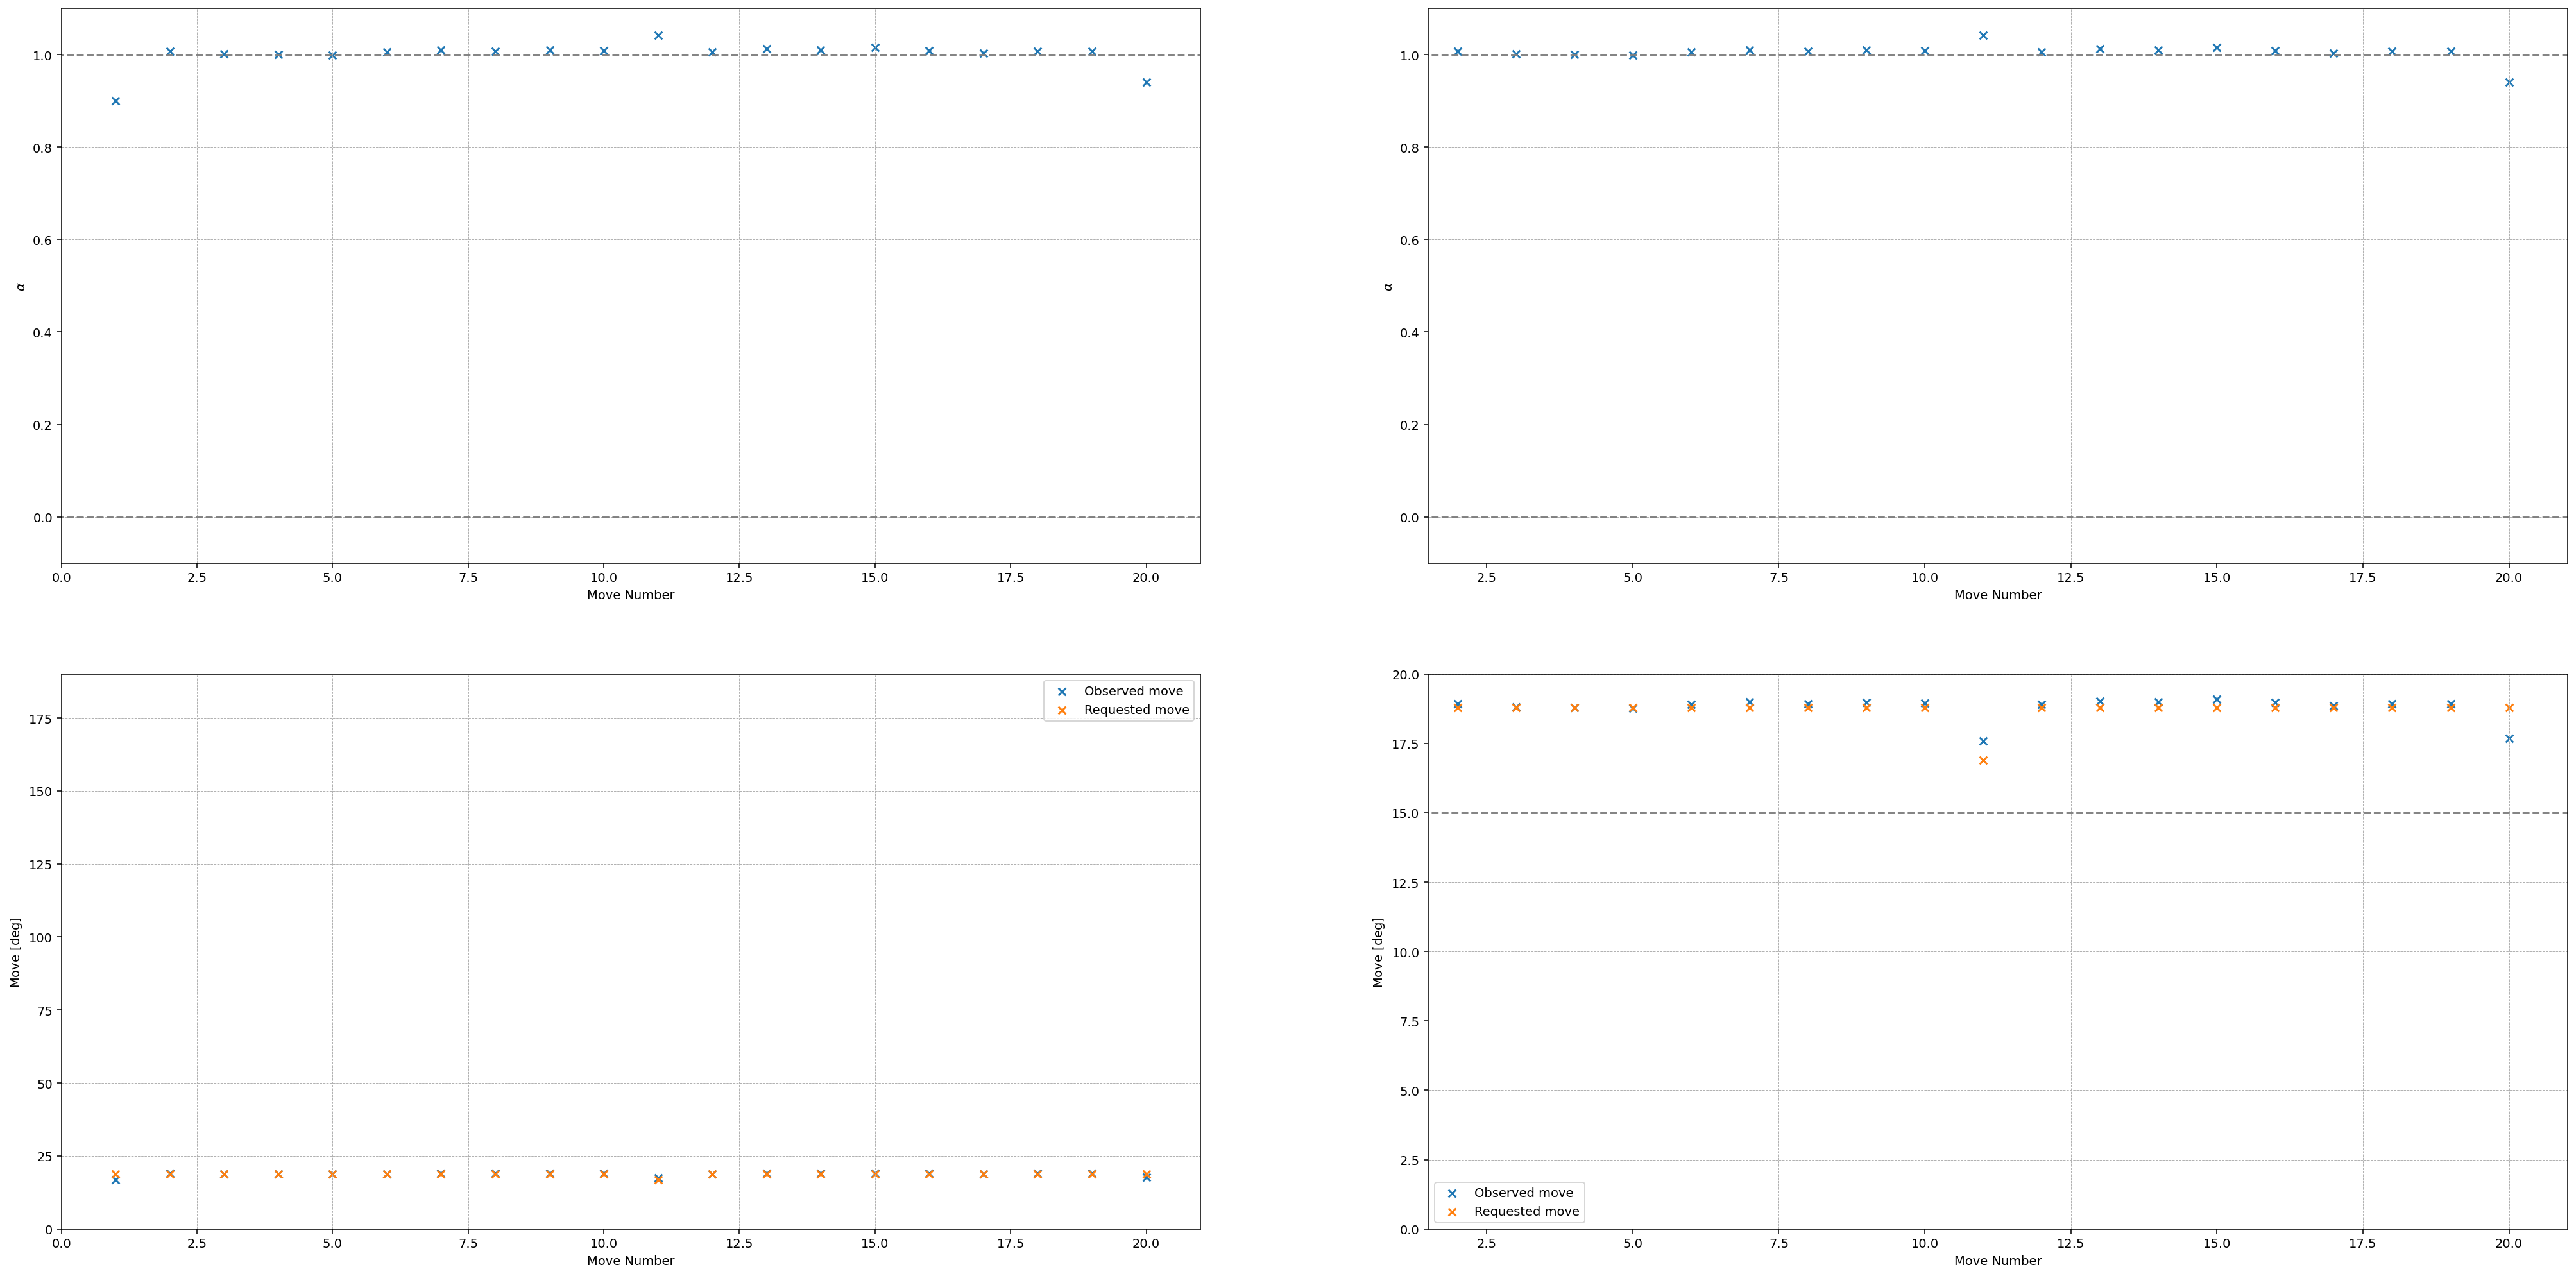

In [600]:
fig,axs = plt.subplots(2,2,figsize=[36,18])

axs[0][0].set_ylim(-0.1,1.1)
axs[0][0].grid(linestyle='--',linewidth=0.5)
axs[0][0].hlines(0,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0][0].hlines(1,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0][0].set_xlim(0,len(alpha_arr)+1)
axs[0][0].set_xlabel("Move Number")
axs[0][0].set_ylabel(r"$\alpha$")
axs[0][0].scatter(np.linspace(1,len(alpha_arr),num=len(alpha_arr)), alpha_arr,marker='x')

axs[1][0].set_ylim(0,190)
axs[1][0].grid(linestyle='--',linewidth=0.5)
# axs[1].hlines(0,-1,len(req_arr)+1,linestyle='--',colors='grey')
# axs[1].hlines(1,-1,len(req_arr)+1,linestyle='--',colors='grey')
axs[1][0].set_xlim(0,len(req_arr)+1)
axs[1][0].set_xlabel("Move Number")
axs[1][0].set_ylabel(r"Move $[\deg]$")
axs[1][0].scatter(np.linspace(1,len(obs_arr),num=len(obs_arr)), obs_arr,label="Observed move",marker='x')
axs[1][0].scatter(np.linspace(1,len(req_arr),num=len(req_arr)), req_arr,label="Requested move",marker='x')
axs[1][0].legend()

axs[0][1].set_ylim(-0.1,1.1)
axs[0][1].grid(linestyle='--',linewidth=0.5)
axs[0][1].hlines(0,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0][1].hlines(1,-1,len(alpha_arr)+1,linestyle='--',colors='grey')
axs[0][1].set_xlim(1.5,len(alpha_arr)+1)
axs[0][1].set_xlabel("Move Number")
axs[0][1].set_ylabel(r"$\alpha$")
axs[0][1].scatter(np.linspace(1,len(alpha_arr),num=len(alpha_arr)), alpha_arr,marker='x')

axs[1][1].set_ylim(0,20)
axs[1][1].grid(linestyle='--',linewidth=0.5)
axs[1][1].hlines(15,-1,len(req_arr)+1,linestyle='--',colors='grey')
axs[1][1].set_xlim(1.5,len(req_arr)+1)
axs[1][1].set_xlabel("Move Number")
axs[1][1].set_ylabel(r"Move $[\deg]$")
axs[1][1].scatter(np.linspace(1,len(obs_arr),num=len(obs_arr)), obs_arr,label="Observed move",marker='x')
axs[1][1].scatter(np.linspace(1,len(req_arr),num=len(req_arr)), req_arr,label="Requested move",marker='x')
axs[1][1].legend()

plt.savefig('/home/msdos/DESI-QA/output/figures/LinPhiTests/MoveTestJun20.jpg',dpi=180)

plt.show()

In [660]:
db[m2]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
2828,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181503,4852,cw,cruise,phi,0.0,1973.785765,883.588189,0,77898.8032,3.5325
2829,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181512,4852,cw,cruise,phi,15.0,1979.714633,908.418869,0,77275.7543,3.5321
2830,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181521,4852,cw,cruise,phi,15.0,1977.314132,936.896043,0,79230.1590,3.5057
2831,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181530,4852,cw,cruise,phi,15.0,1965.892502,962.908295,0,79071.6460,3.5117
2832,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181539,4852,cw,cruise,phi,15.0,1946.687535,983.787345,0,78332.5607,3.5644
2833,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181548,4852,cw,cruise,phi,15.0,1921.783093,997.270257,0,79032.2880,3.5764
2834,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181557,4852,cw,cruise,phi,15.0,1893.689271,1002.094749,0,79134.7267,3.6332
2835,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181605,4852,cw,cruise,phi,15.0,1865.427622,997.564750,0,78596.3498,3.6798
2836,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181614,4852,cw,cruise,phi,15.0,1840.230767,984.141420,0,79442.3825,3.6999
2837,arcph15,2023-06-20 18:15:01,0.0,0.0,20230620-181623,4852,cw,cruise,phi,15.0,1820.675182,963.215341,0,79754.5174,3.7573


# UPDATE THE CODE WITH THE VALUES ABOVE

In [ ]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4} \nR2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

In [ ]:
ddd = np.array([124.27, 143.27, 163.17, 180])
ddd[1:] - ddd[:-1]

In [ ]:
ddd = np.array([3.8867,26.4787, 58.06, 89.65, 59.5557, 27.9447])
ddd[1:] - ddd[:-1], 15*50/33 +2*4.53, (15 + 2*4.53) * 50/33

In [ ]:
(15 - 2)*50/33 + 2*4.53

In [812]:
!pwd

/home/msdos/DESI-QA/calib


<ErrorbarContainer object of 3 artists>

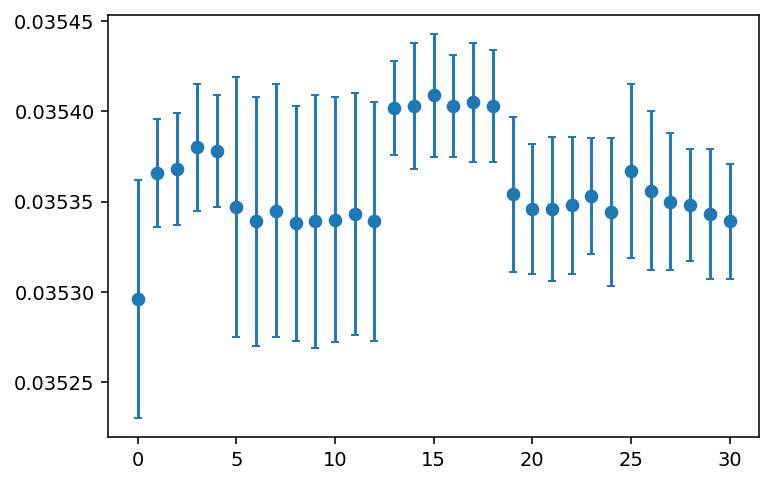

In [835]:
dfid = pd.read_csv("../output/fiddb.csv")
plt.errorbar(np.arange(len(dfid['pix2mm'])), dfid['pix2mm'], yerr=dfid.sigpix2mm, capsize=2, fmt='o')

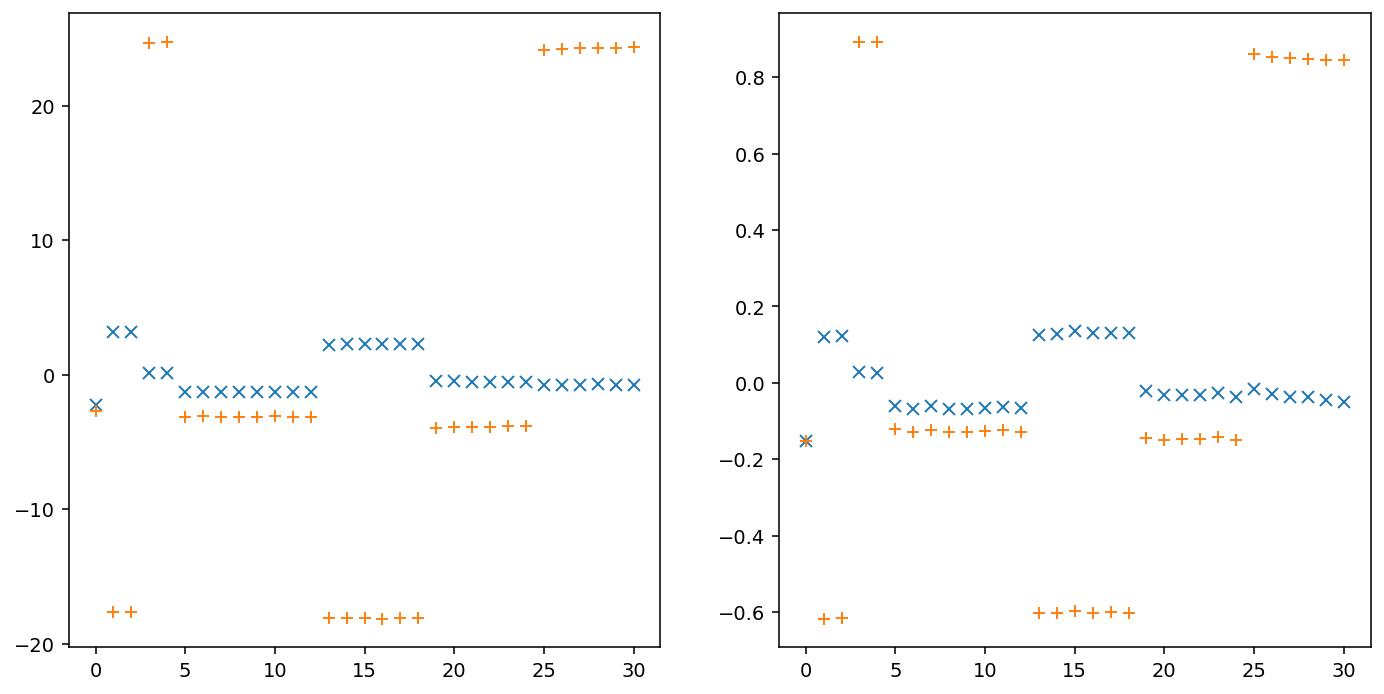

In [853]:
fig,axs = plt.subplots(1,2,figsize=[12,6])

xfidcm = dfid.filter(regex='^x').mean(axis=1)#*dfid.pix2mm
yfidcm = dfid.filter(regex='^y').mean(axis=1)#*dfid.pix2mm 

axs[0].plot(xfidcm - xfidcm.mean(), 'x')
axs[0].plot(yfidcm - yfidcm.mean(),'+')


xfidcm = dfid.filter(regex='^x').mean(axis=1)*dfid.pix2mm
yfidcm = dfid.filter(regex='^y').mean(axis=1)*dfid.pix2mm

axs[1].plot(xfidcm - xfidcm.mean(), 'x')
axs[1].plot(yfidcm - yfidcm.mean(),'+')

plt.show()

In [821]:
dfid["session"]

0     curreposition-20230622-210527
1            xysafe-20230623-181340
2            xysafe-20230623-181340
3            xysafe-20230623-181340
4            xysafe-20230623-181340
5     curreposition-20230624-175445
6     curreposition-20230624-180942
7            xysafe-20230624-181012
8            xysafe-20230624-181012
9            xysafe-20230624-181012
10           xysafe-20230624-181012
11           xysafe-20230624-181012
12           xysafe-20230624-181012
13           xysafe-20230624-181012
14           xysafe-20230624-181012
15           xysafe-20230624-181012
16           xysafe-20230624-181012
17           xysafe-20230624-181012
18           xysafe-20230624-181012
19           xysafe-20230624-181012
20           xysafe-20230624-181012
21           xysafe-20230624-181012
22           xysafe-20230624-181012
23           xysafe-20230624-181012
24           xysafe-20230624-181012
25           xysafe-20230624-181012
26           xysafe-20230624-181012
27           xysafe-20230624

/home/msdos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False